In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(337576, 828)
(337576, 1)
validation
(56520, 828)
(56520, 1)
test
(26800, 828)
(26800, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/34 [..............................] - ETA: 39s - loss: 0.0156 - STD: 1.3133e-04 - MAE: 0.0906

 4/34 [==>...........................] - ETA: 0s - loss: 0.0203 - STD: 4.3823e-04 - MAE: 0.1019 

 5/34 [===>..........................] - ETA: 1s - loss: 0.0202 - STD: 5.9708e-04 - MAE: 0.1056

 6/34 [====>.........................] - ETA: 1s - loss: 0.0194 - STD: 7.1577e-04 - MAE: 0.1024

 7/34 [=====>........................] - ETA: 1s - loss: 0.0190 - STD: 8.0317e-04 - MAE: 0.0979

 8/34 [======>.......................] - ETA: 3s - loss: 0.0189 - STD: 8.8139e-04 - MAE: 0.0952

12/34 [=========>....................] - ETA: 2s - loss: 0.0181 - STD: 0.0013 - MAE: 0.0902    

13/34 [==========>...................] - ETA: 1s - loss: 0.0180 - STD: 0.0014 - MAE: 0.0913

14/34 [===========>..................] - ETA: 1s - loss: 0.0179 - STD: 0.0016 - MAE: 0.0920

15/34 [============>.................] - ETA: 1s - loss: 0.0177 - STD: 0.0017 - MAE: 0.0919

16/34 [=============>................] - ETA: 1s - loss: 0.0175 - STD: 0.0018 - MAE: 0.0912

17/34 [==============>...............] - ETA: 1s - loss: 0.0174 - STD: 0.0019 - MAE: 0.0902

18/34 [==============>...............] - ETA: 1s - loss: 0.0173 - STD: 0.0020 - MAE: 0.0891

19/34 [===============>..............] - ETA: 1s - loss: 0.0172 - STD: 0.0021 - MAE: 0.0882

20/34 [================>.............] - ETA: 1s - loss: 0.0172 - STD: 0.0023 - MAE: 0.0874

21/34 [=================>............] - ETA: 1s - loss: 0.0170 - STD: 0.0024 - MAE: 0.0868

22/34 [==================>...........] - ETA: 0s - loss: 0.0169 - STD: 0.0026 - MAE: 0.0865

23/34 [===================>..........] - ETA: 0s - loss: 0.0168 - STD: 0.0027 - MAE: 0.0865

24/34 [====================>.........] - ETA: 0s - loss: 0.0168 - STD: 0.0029 - MAE: 0.0867

25/34 [=====================>........] - ETA: 0s - loss: 0.0167 - STD: 0.0032 - MAE: 0.0868

26/34 [=====================>........] - ETA: 0s - loss: 0.0166 - STD: 0.0034 - MAE: 0.0867

27/34 [======================>.......] - ETA: 0s - loss: 0.0165 - STD: 0.0036 - MAE: 0.0863

28/34 [=======================>......] - ETA: 0s - loss: 0.0164 - STD: 0.0039 - MAE: 0.0858

29/34 [========================>.....] - ETA: 0s - loss: 0.0163 - STD: 0.0041 - MAE: 0.0853

30/34 [=========================>....] - ETA: 0s - loss: 0.0163 - STD: 0.0044 - MAE: 0.0848

31/34 [==========================>...] - ETA: 0s - loss: 0.0161 - STD: 0.0048 - MAE: 0.0843

32/34 [===========================>..] - ETA: 0s - loss: 0.0161 - STD: 0.0052 - MAE: 0.0840

33/34 [============================>.] - ETA: 0s - loss: 0.0160 - STD: 0.0056 - MAE: 0.0838

34/34 [==============================] - ETA: 0s - loss: 0.0159 - STD: 0.0061 - MAE: 0.0836

34/34 [==============================] - 4s 94ms/step - loss: 0.0159 - STD: 0.0061 - MAE: 0.0836 - val_loss: 0.0133 - val_STD: 0.0212 - val_MAE: 0.0819


Epoch 2/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0124 - STD: 0.0259 - MAE: 0.0765

 2/34 [>.............................] - ETA: 2s - loss: 0.0119 - STD: 0.0274 - MAE: 0.0738

 3/34 [=>............................] - ETA: 2s - loss: 0.0116 - STD: 0.0289 - MAE: 0.0709

 4/34 [==>...........................] - ETA: 1s - loss: 0.0115 - STD: 0.0306 - MAE: 0.0694

 5/34 [===>..........................] - ETA: 1s - loss: 0.0114 - STD: 0.0325 - MAE: 0.0683

 6/34 [====>.........................] - ETA: 1s - loss: 0.0111 - STD: 0.0348 - MAE: 0.0674

 7/34 [=====>........................] - ETA: 1s - loss: 0.0109 - STD: 0.0374 - MAE: 0.0669

 8/34 [======>.......................] - ETA: 1s - loss: 0.0106 - STD: 0.0402 - MAE: 0.0665

10/34 [=======>......................] - ETA: 1s - loss: 0.0102 - STD: 0.0457 - MAE: 0.0654

11/34 [========>.....................] - ETA: 1s - loss: 0.0100 - STD: 0.0484 - MAE: 0.0648

12/34 [=========>....................] - ETA: 1s - loss: 0.0098 - STD: 0.0510 - MAE: 0.0643

13/34 [==========>...................] - ETA: 1s - loss: 0.0095 - STD: 0.0538 - MAE: 0.0637

14/34 [===========>..................] - ETA: 1s - loss: 0.0094 - STD: 0.0567 - MAE: 0.0633

15/34 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 0.0592 - MAE: 0.0628

16/34 [=============>................] - ETA: 1s - loss: 0.0089 - STD: 0.0613 - MAE: 0.0621

17/34 [==============>...............] - ETA: 1s - loss: 0.0088 - STD: 0.0631 - MAE: 0.0616

18/34 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 0.0648 - MAE: 0.0610

19/34 [===============>..............] - ETA: 0s - loss: 0.0084 - STD: 0.0664 - MAE: 0.0604

20/34 [================>.............] - ETA: 0s - loss: 0.0083 - STD: 0.0679 - MAE: 0.0599

21/34 [=================>............] - ETA: 0s - loss: 0.0081 - STD: 0.0691 - MAE: 0.0594

22/34 [==================>...........] - ETA: 0s - loss: 0.0080 - STD: 0.0701 - MAE: 0.0588

23/34 [===================>..........] - ETA: 0s - loss: 0.0079 - STD: 0.0712 - MAE: 0.0583

24/34 [====================>.........] - ETA: 0s - loss: 0.0078 - STD: 0.0722 - MAE: 0.0579

25/34 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.0733 - MAE: 0.0575

26/34 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0746 - MAE: 0.0571

27/34 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.0756 - MAE: 0.0567

28/34 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0767 - MAE: 0.0564

29/34 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0778 - MAE: 0.0561

30/34 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0789 - MAE: 0.0557

31/34 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0798 - MAE: 0.0554

32/34 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0805 - MAE: 0.0551

33/34 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.0810 - MAE: 0.0549

34/34 [==============================] - ETA: 0s - loss: 0.0070 - STD: 0.0817 - MAE: 0.0546

34/34 [==============================] - 2s 71ms/step - loss: 0.0070 - STD: 0.0817 - MAE: 0.0546 - val_loss: 0.0084 - val_STD: 0.0843 - val_MAE: 0.0630


Epoch 3/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.1036 - MAE: 0.0460

 2/34 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.1040 - MAE: 0.0461

 3/34 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.1038 - MAE: 0.0459

 4/34 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.1033 - MAE: 0.0456

 5/34 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.1043 - MAE: 0.0455

 6/34 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.1053 - MAE: 0.0456

 7/34 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.1061 - MAE: 0.0455

 8/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.1058 - MAE: 0.0455

 9/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.1055 - MAE: 0.0454

10/34 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.1057 - MAE: 0.0453

11/34 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.1056 - MAE: 0.0452

12/34 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.1053 - MAE: 0.0451

13/34 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.1047 - MAE: 0.0450

14/34 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.1046 - MAE: 0.0450

15/34 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.1048 - MAE: 0.0451

17/34 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.1044 - MAE: 0.0450

18/34 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.1044 - MAE: 0.0450

19/34 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.1048 - MAE: 0.0450

20/34 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.1049 - MAE: 0.0450

21/34 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.1049 - MAE: 0.0450

22/34 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.1047 - MAE: 0.0449

23/34 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.1047 - MAE: 0.0449

24/34 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.1046 - MAE: 0.0449

25/34 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.1045 - MAE: 0.0449

26/34 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.1045 - MAE: 0.0448

27/34 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.1045 - MAE: 0.0448

28/34 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.1046 - MAE: 0.0447

29/34 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.1047 - MAE: 0.0447

30/34 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.1047 - MAE: 0.0446

31/34 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.1047 - MAE: 0.0446

32/34 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.1048 - MAE: 0.0446

33/34 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.1047 - MAE: 0.0446

34/34 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.1047 - MAE: 0.0445

34/34 [==============================] - 2s 71ms/step - loss: 0.0045 - STD: 0.1047 - MAE: 0.0445 - val_loss: 0.0092 - val_STD: 0.0945 - val_MAE: 0.0664


Epoch 4/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.1049 - MAE: 0.0439

 2/34 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.1047 - MAE: 0.0436

 3/34 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.1043 - MAE: 0.0433

 4/34 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.1048 - MAE: 0.0435

 5/34 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.1053 - MAE: 0.0435

 6/34 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.1055 - MAE: 0.0432

 7/34 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.1058 - MAE: 0.0432

 8/34 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.1063 - MAE: 0.0432

 9/34 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.1063 - MAE: 0.0431

10/34 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.1060 - MAE: 0.0431

11/34 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.1060 - MAE: 0.0431

12/34 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.1060 - MAE: 0.0431

13/34 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.1057 - MAE: 0.0431

14/34 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.1057 - MAE: 0.0430

15/34 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.1058 - MAE: 0.0430

16/34 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.1060 - MAE: 0.0429

18/34 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.1060 - MAE: 0.0429

19/34 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.1061 - MAE: 0.0429

20/34 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.1061 - MAE: 0.0429

21/34 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.1061 - MAE: 0.0429

22/34 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.1063 - MAE: 0.0429

23/34 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.1063 - MAE: 0.0429

24/34 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.1064 - MAE: 0.0429

25/34 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.1065 - MAE: 0.0429

26/34 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.1064 - MAE: 0.0429

27/34 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.1063 - MAE: 0.0429

28/34 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.1062 - MAE: 0.0429

29/34 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.1062 - MAE: 0.0429

30/34 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.1060 - MAE: 0.0428

31/34 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.1060 - MAE: 0.0428

32/34 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.1061 - MAE: 0.0428

33/34 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.1060 - MAE: 0.0428

34/34 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.1061 - MAE: 0.0427

34/34 [==============================] - 2s 68ms/step - loss: 0.0041 - STD: 0.1061 - MAE: 0.0427 - val_loss: 0.0099 - val_STD: 0.0990 - val_MAE: 0.0683


Epoch 5/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.1096 - MAE: 0.0418

 2/34 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.1079 - MAE: 0.0419

 3/34 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.1070 - MAE: 0.0419

 4/34 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.1075 - MAE: 0.0419

 5/34 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.1074 - MAE: 0.0419

 6/34 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.1066 - MAE: 0.0420

 7/34 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.1071 - MAE: 0.0422

 8/34 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.1073 - MAE: 0.0421

 9/34 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.1069 - MAE: 0.0422

10/34 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.1073 - MAE: 0.0423

11/34 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.1076 - MAE: 0.0423

12/34 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.1072 - MAE: 0.0422

13/34 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.1072 - MAE: 0.0421

14/34 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.1074 - MAE: 0.0422

15/34 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.1072 - MAE: 0.0421

16/34 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.1071 - MAE: 0.0420

17/34 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.1072 - MAE: 0.0420

18/34 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.1072 - MAE: 0.0419

19/34 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.1071 - MAE: 0.0419

20/34 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.1072 - MAE: 0.0418

21/34 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.1072 - MAE: 0.0418

22/34 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.1072 - MAE: 0.0418

23/34 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.1071 - MAE: 0.0417

24/34 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.1071 - MAE: 0.0417

25/34 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.1071 - MAE: 0.0416

26/34 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.1071 - MAE: 0.0416

27/34 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.1071 - MAE: 0.0416

28/34 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.1070 - MAE: 0.0416

29/34 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.1069 - MAE: 0.0415

30/34 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.1070 - MAE: 0.0415

32/34 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.1069 - MAE: 0.0415

33/34 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.1070 - MAE: 0.0415

34/34 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.1069 - MAE: 0.0414

34/34 [==============================] - 2s 69ms/step - loss: 0.0039 - STD: 0.1069 - MAE: 0.0414 - val_loss: 0.0087 - val_STD: 0.0982 - val_MAE: 0.0645


Epoch 6/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.1102 - MAE: 0.0419

 2/34 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.1097 - MAE: 0.0412

 3/34 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.1084 - MAE: 0.0408

 4/34 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.1082 - MAE: 0.0409

 5/34 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.1082 - MAE: 0.0409

 6/34 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.1078 - MAE: 0.0408

 7/34 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.1078 - MAE: 0.0407

 8/34 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.1079 - MAE: 0.0407

 9/34 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.1078 - MAE: 0.0406

10/34 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.1084 - MAE: 0.0407

11/34 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.1082 - MAE: 0.0408

12/34 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.1086 - MAE: 0.0408

13/34 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.1083 - MAE: 0.0407

14/34 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.1081 - MAE: 0.0406

15/34 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.1080 - MAE: 0.0406

16/34 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.1078 - MAE: 0.0406

17/34 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.1079 - MAE: 0.0406

18/34 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.1078 - MAE: 0.0405

19/34 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.1079 - MAE: 0.0405

20/34 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.1081 - MAE: 0.0405

21/34 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.1083 - MAE: 0.0405

22/34 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.1082 - MAE: 0.0404

23/34 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.1082 - MAE: 0.0404

24/34 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.1080 - MAE: 0.0404

25/34 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.1080 - MAE: 0.0404

26/34 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.1079 - MAE: 0.0404

28/34 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.1080 - MAE: 0.0403

29/34 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.1080 - MAE: 0.0403

30/34 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.1081 - MAE: 0.0403

31/34 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.1080 - MAE: 0.0403

32/34 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.1080 - MAE: 0.0403

33/34 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.1079 - MAE: 0.0402

34/34 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.1079 - MAE: 0.0402

34/34 [==============================] - 2s 71ms/step - loss: 0.0036 - STD: 0.1079 - MAE: 0.0402 - val_loss: 0.0071 - val_STD: 0.0939 - val_MAE: 0.0584


Epoch 7/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.1070 - MAE: 0.0395

 2/34 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.1089 - MAE: 0.0397

 3/34 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.1081 - MAE: 0.0396

 4/34 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.1097 - MAE: 0.0397

 5/34 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.1091 - MAE: 0.0398

 6/34 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.1093 - MAE: 0.0400

 7/34 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.1094 - MAE: 0.0401

 8/34 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.1084 - MAE: 0.0401

 9/34 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.1087 - MAE: 0.0406

10/34 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.1076 - MAE: 0.0408

11/34 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.1081 - MAE: 0.0409

12/34 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.1082 - MAE: 0.0408

13/34 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.1077 - MAE: 0.0409

14/34 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.1083 - MAE: 0.0413

15/34 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.1079 - MAE: 0.0412

16/34 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.1078 - MAE: 0.0411

17/34 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.1081 - MAE: 0.0413

18/34 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.1078 - MAE: 0.0413

19/34 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0412

20/34 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.1080 - MAE: 0.0414

21/34 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.1075 - MAE: 0.0414

22/34 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.1074 - MAE: 0.0413

23/34 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.1078 - MAE: 0.0414

24/34 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0414

25/34 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0414

26/34 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.1079 - MAE: 0.0415

27/34 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.1079 - MAE: 0.0414

28/34 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.1076 - MAE: 0.0413

29/34 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.1077 - MAE: 0.0412

31/34 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.1079 - MAE: 0.0412

32/34 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.1077 - MAE: 0.0411

33/34 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.1079 - MAE: 0.0411

34/34 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.1080 - MAE: 0.0410

34/34 [==============================] - 2s 71ms/step - loss: 0.0037 - STD: 0.1080 - MAE: 0.0410 - val_loss: 0.0061 - val_STD: 0.0913 - val_MAE: 0.0541


Epoch 8/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.1032 - MAE: 0.0387

 2/34 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.1072 - MAE: 0.0387

 3/34 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.1086 - MAE: 0.0393

 4/34 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.1082 - MAE: 0.0391

 5/34 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.1075 - MAE: 0.0390

 6/34 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.1080 - MAE: 0.0392

 8/34 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.1079 - MAE: 0.0391

 9/34 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.1085 - MAE: 0.0391

10/34 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.1089 - MAE: 0.0392

11/34 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.1087 - MAE: 0.0393

12/34 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.1090 - MAE: 0.0393

13/34 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.1092 - MAE: 0.0392

14/34 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.1088 - MAE: 0.0392

15/34 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.1087 - MAE: 0.0391

16/34 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.1089 - MAE: 0.0392

17/34 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.1088 - MAE: 0.0392

18/34 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.1086 - MAE: 0.0391

19/34 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.1088 - MAE: 0.0392

20/34 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.1086 - MAE: 0.0392

21/34 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.1084 - MAE: 0.0391

22/34 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.1086 - MAE: 0.0392

23/34 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.1085 - MAE: 0.0391

24/34 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.1085 - MAE: 0.0391

25/34 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.1086 - MAE: 0.0392

26/34 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.1088 - MAE: 0.0392

27/34 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.1086 - MAE: 0.0391

28/34 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.1086 - MAE: 0.0391

29/34 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.1088 - MAE: 0.0392

30/34 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1086 - MAE: 0.0391

31/34 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1087 - MAE: 0.0391

32/34 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1087 - MAE: 0.0392

33/34 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1088 - MAE: 0.0392

34/34 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1088 - MAE: 0.0392

34/34 [==============================] - 2s 70ms/step - loss: 0.0035 - STD: 0.1088 - MAE: 0.0392 - val_loss: 0.0063 - val_STD: 0.0962 - val_MAE: 0.0555


Epoch 9/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0387

 2/34 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.1095 - MAE: 0.0386

 3/34 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.1100 - MAE: 0.0384

 4/34 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1100 - MAE: 0.0384

 5/34 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0383

 6/34 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.1092 - MAE: 0.0384

 7/34 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0387

 8/34 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0386

 9/34 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0386

10/34 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0386

11/34 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0385

12/34 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.1094 - MAE: 0.0385

13/34 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.1097 - MAE: 0.0387

14/34 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.1099 - MAE: 0.0386

15/34 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0387

16/34 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.1101 - MAE: 0.0388

17/34 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0388

18/34 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0387

20/34 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.1094 - MAE: 0.0387

21/34 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0387

22/34 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0387

23/34 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.1094 - MAE: 0.0387

24/34 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0388

25/34 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0388

26/34 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1093 - MAE: 0.0387

27/34 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1094 - MAE: 0.0388

28/34 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1094 - MAE: 0.0388

29/34 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1093 - MAE: 0.0387

30/34 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1094 - MAE: 0.0388

31/34 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0388

32/34 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0388

33/34 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1096 - MAE: 0.0388

34/34 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0388

34/34 [==============================] - 2s 71ms/step - loss: 0.0034 - STD: 0.1095 - MAE: 0.0388 - val_loss: 0.0057 - val_STD: 0.0937 - val_MAE: 0.0526


Epoch 10/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.1128 - MAE: 0.0381

 2/34 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.1110 - MAE: 0.0383

 4/34 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.1078 - MAE: 0.0377

 5/34 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.1088 - MAE: 0.0379

 6/34 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.1088 - MAE: 0.0380

 7/34 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.1086 - MAE: 0.0380

 8/34 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1093 - MAE: 0.0381

 9/34 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1092 - MAE: 0.0381

10/34 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1093 - MAE: 0.0381

11/34 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.1092 - MAE: 0.0381

12/34 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.1092 - MAE: 0.0380

13/34 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1094 - MAE: 0.0380

14/34 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.1095 - MAE: 0.0381

15/34 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.1095 - MAE: 0.0381

16/34 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0382

17/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0382

18/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0382

19/34 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0382

20/34 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0382

21/34 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0382

22/34 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0382

23/34 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0381

24/34 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0382

25/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0382

26/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0382

27/34 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0382

28/34 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0382

29/34 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0382

30/34 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0382

31/34 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0382

32/34 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0382

33/34 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0382

34/34 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0382

34/34 [==============================] - 2s 70ms/step - loss: 0.0033 - STD: 0.1099 - MAE: 0.0382 - val_loss: 0.0053 - val_STD: 0.0917 - val_MAE: 0.0499


Epoch 11/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.1066 - MAE: 0.0381

 2/34 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.1090 - MAE: 0.0380

 3/34 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.1095 - MAE: 0.0380

 4/34 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1090 - MAE: 0.0382

 5/34 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0385

 6/34 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1094 - MAE: 0.0384

 7/34 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0383

 8/34 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0384

 9/34 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0385

10/34 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1100 - MAE: 0.0388

11/34 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.1094 - MAE: 0.0389

12/34 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0388

13/34 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0387

14/34 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0387

16/34 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0387

17/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0386

18/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0387

19/34 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.1094 - MAE: 0.0387

20/34 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.1097 - MAE: 0.0388

21/34 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0388

22/34 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0387

23/34 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0388

24/34 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.1097 - MAE: 0.0388

25/34 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0388

26/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1099 - MAE: 0.0388

27/34 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0388

28/34 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1099 - MAE: 0.0388

29/34 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0388

30/34 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0388

31/34 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1100 - MAE: 0.0388

32/34 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0388

33/34 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0388

34/34 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.1100 - MAE: 0.0389

34/34 [==============================] - 2s 70ms/step - loss: 0.0034 - STD: 0.1100 - MAE: 0.0389 - val_loss: 0.0054 - val_STD: 0.0854 - val_MAE: 0.0488


Epoch 12/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.1018 - MAE: 0.0405

 2/34 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.1056 - MAE: 0.0396

 3/34 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.1081 - MAE: 0.0392

 4/34 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.1077 - MAE: 0.0392

 5/34 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.1090 - MAE: 0.0390

 6/34 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0389

 7/34 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.1092 - MAE: 0.0390

 8/34 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.1099 - MAE: 0.0390

 9/34 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.1098 - MAE: 0.0389

10/34 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.1093 - MAE: 0.0388

11/34 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0388

12/34 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.1095 - MAE: 0.0387

13/34 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1093 - MAE: 0.0386

14/34 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.1095 - MAE: 0.0386

15/34 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0385

16/34 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0385

17/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0384

18/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0384

19/34 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0384

20/34 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0384

21/34 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0383

22/34 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.1095 - MAE: 0.0383

23/34 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0384

24/34 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0383

25/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0383

26/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1100 - MAE: 0.0385

27/34 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0386

28/34 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1098 - MAE: 0.0386

30/34 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0387

31/34 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0387

32/34 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1097 - MAE: 0.0388

33/34 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1095 - MAE: 0.0388

34/34 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0388

34/34 [==============================] - 2s 70ms/step - loss: 0.0033 - STD: 0.1096 - MAE: 0.0388 - val_loss: 0.0054 - val_STD: 0.0985 - val_MAE: 0.0515


Epoch 13/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.1179 - MAE: 0.0389

 2/34 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.1116 - MAE: 0.0393

 3/34 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.1120 - MAE: 0.0389

 4/34 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.1133 - MAE: 0.0392

 5/34 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.1113 - MAE: 0.0389

 6/34 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1104 - MAE: 0.0385

 7/34 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.1109 - MAE: 0.0387

 8/34 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1106 - MAE: 0.0387

 9/34 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1105 - MAE: 0.0386

10/34 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1108 - MAE: 0.0385

11/34 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.1108 - MAE: 0.0384

12/34 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.1107 - MAE: 0.0384

13/34 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1112 - MAE: 0.0385

14/34 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.1110 - MAE: 0.0384

15/34 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.1108 - MAE: 0.0384

16/34 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.1110 - MAE: 0.0385

17/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1106 - MAE: 0.0384

18/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1105 - MAE: 0.0383

19/34 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.1107 - MAE: 0.0384

20/34 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.1104 - MAE: 0.0383

21/34 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.1105 - MAE: 0.0383

22/34 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.1106 - MAE: 0.0383

23/34 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1105 - MAE: 0.0383

24/34 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.1105 - MAE: 0.0382

25/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1106 - MAE: 0.0382

26/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0382

27/34 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0382

28/34 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1103 - MAE: 0.0382

29/34 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0381

31/34 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1104 - MAE: 0.0381

32/34 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0381

33/34 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0380

34/34 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1105 - MAE: 0.0380

34/34 [==============================] - 2s 71ms/step - loss: 0.0032 - STD: 0.1105 - MAE: 0.0380 - val_loss: 0.0051 - val_STD: 0.0910 - val_MAE: 0.0483


Epoch 14/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.1064 - MAE: 0.0376

 2/34 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.1080 - MAE: 0.0373

 3/34 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.1092 - MAE: 0.0376

 4/34 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.1090 - MAE: 0.0375

 5/34 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.1098 - MAE: 0.0375

 6/34 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0376

 7/34 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0376

 8/34 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.1109 - MAE: 0.0377

 9/34 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.1114 - MAE: 0.0377

10/34 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.1109 - MAE: 0.0377

11/34 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.1109 - MAE: 0.0377

12/34 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.1109 - MAE: 0.0377

13/34 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.1101 - MAE: 0.0378

14/34 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.1101 - MAE: 0.0379

16/34 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.1097 - MAE: 0.0379

17/34 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.1099 - MAE: 0.0379

18/34 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.1101 - MAE: 0.0378

19/34 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.1100 - MAE: 0.0378

20/34 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0379

21/34 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0379

22/34 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.1100 - MAE: 0.0379

23/34 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.1101 - MAE: 0.0379

24/34 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.1101 - MAE: 0.0379

25/34 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1100 - MAE: 0.0379

26/34 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1101 - MAE: 0.0379

27/34 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1102 - MAE: 0.0379

28/34 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.1102 - MAE: 0.0379

29/34 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0379

30/34 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1103 - MAE: 0.0379

31/34 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1104 - MAE: 0.0379

32/34 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1105 - MAE: 0.0378

33/34 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1104 - MAE: 0.0378

34/34 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1105 - MAE: 0.0378

34/34 [==============================] - 2s 70ms/step - loss: 0.0032 - STD: 0.1105 - MAE: 0.0378 - val_loss: 0.0051 - val_STD: 0.0933 - val_MAE: 0.0488


Epoch 15/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.1084 - MAE: 0.0372

 2/34 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.1091 - MAE: 0.0372

 3/34 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.1105 - MAE: 0.0376

 4/34 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1105 - MAE: 0.0374

 5/34 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.1100 - MAE: 0.0373

 6/34 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1098 - MAE: 0.0372

 7/34 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1098 - MAE: 0.0372

 8/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1096 - MAE: 0.0371

 9/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1100 - MAE: 0.0371

10/34 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.1099 - MAE: 0.0371

11/34 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.1099 - MAE: 0.0371

12/34 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1103 - MAE: 0.0372

13/34 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0373

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0373

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0373

17/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0373

18/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0373

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0373

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0373

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0373

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0372

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0373

24/34 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0373

25/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0373

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0373

27/34 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0373

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0373

29/34 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1105 - MAE: 0.0373

30/34 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0373

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0373

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0373

33/34 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0373

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0373

34/34 [==============================] - 2s 68ms/step - loss: 0.0031 - STD: 0.1109 - MAE: 0.0373 - val_loss: 0.0050 - val_STD: 0.0936 - val_MAE: 0.0480


Epoch 16/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1092 - MAE: 0.0360

 2/34 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1103 - MAE: 0.0367

 3/34 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1106 - MAE: 0.0367

 4/34 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1102 - MAE: 0.0369

 5/34 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1101 - MAE: 0.0368

 6/34 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0370

 7/34 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0370

 8/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0372

 9/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0372

10/34 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0372

11/34 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0373

12/34 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0372

13/34 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0372

14/34 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0372

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0372

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0374

17/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0374

18/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0375

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0375

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1105 - MAE: 0.0374

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0375

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1105 - MAE: 0.0375

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0374

24/34 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0374

25/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0375

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0375

27/34 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0375

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0375

29/34 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0375

30/34 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0375

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0375

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0375

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0374

34/34 [==============================] - 2s 70ms/step - loss: 0.0031 - STD: 0.1109 - MAE: 0.0374 - val_loss: 0.0049 - val_STD: 0.0930 - val_MAE: 0.0475


Epoch 17/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1066 - MAE: 0.0361

 2/34 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0368

 3/34 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.1102 - MAE: 0.0368

 5/34 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1103 - MAE: 0.0368

 6/34 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0369

 7/34 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1103 - MAE: 0.0370

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1102 - MAE: 0.0369

 9/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1099 - MAE: 0.0369

10/34 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1098 - MAE: 0.0368

11/34 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1101 - MAE: 0.0369

12/34 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1098 - MAE: 0.0370

13/34 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1103 - MAE: 0.0370

14/34 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1102 - MAE: 0.0370

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0371

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0371

17/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0370

18/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0370

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0370

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0370

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0371

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0371

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0372

24/34 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0372

25/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0373

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0374

27/34 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0374

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0374

29/34 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0374

30/34 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0374

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0375

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0375

33/34 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0375

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0375

34/34 [==============================] - 2s 69ms/step - loss: 0.0031 - STD: 0.1110 - MAE: 0.0375 - val_loss: 0.0052 - val_STD: 0.0964 - val_MAE: 0.0510


Epoch 18/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.1113 - MAE: 0.0391

 2/34 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.1069 - MAE: 0.0386

 3/34 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.1096 - MAE: 0.0387

 4/34 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.1108 - MAE: 0.0383

 5/34 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.1101 - MAE: 0.0382

 6/34 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1120 - MAE: 0.0387

 7/34 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.1105 - MAE: 0.0390

 8/34 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1108 - MAE: 0.0389

 9/34 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1109 - MAE: 0.0388

10/34 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0387

11/34 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.1106 - MAE: 0.0388

12/34 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.1102 - MAE: 0.0388

13/34 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1108 - MAE: 0.0387

14/34 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.1113 - MAE: 0.0386

15/34 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.1107 - MAE: 0.0386

16/34 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.1111 - MAE: 0.0388

17/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1109 - MAE: 0.0387

18/34 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1105 - MAE: 0.0386

19/34 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.1108 - MAE: 0.0388

20/34 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.1106 - MAE: 0.0388

21/34 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.1105 - MAE: 0.0387

22/34 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.1110 - MAE: 0.0387

23/34 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1107 - MAE: 0.0387

24/34 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.1107 - MAE: 0.0386

25/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1110 - MAE: 0.0386

26/34 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1108 - MAE: 0.0386

28/34 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1108 - MAE: 0.0385

29/34 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1106 - MAE: 0.0384

30/34 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1105 - MAE: 0.0384

31/34 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1107 - MAE: 0.0384

32/34 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1105 - MAE: 0.0383

33/34 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1106 - MAE: 0.0383

34/34 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1106 - MAE: 0.0382

34/34 [==============================] - 2s 70ms/step - loss: 0.0032 - STD: 0.1106 - MAE: 0.0382 - val_loss: 0.0049 - val_STD: 0.0919 - val_MAE: 0.0466


Epoch 19/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.1101 - MAE: 0.0375

 2/34 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.1123 - MAE: 0.0381

 3/34 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.1110 - MAE: 0.0375

 4/34 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0372

 5/34 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.1117 - MAE: 0.0373

 6/34 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0372

 7/34 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0372

 8/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1119 - MAE: 0.0374

 9/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0373

10/34 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0372

11/34 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0373

12/34 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0374

13/34 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0374

14/34 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0374

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0374

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0374

17/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0375

18/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0374

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0374

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0374

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1103 - MAE: 0.0375

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0375

24/34 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0375

25/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0375

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0375

27/34 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0374

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0375

29/34 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0374

30/34 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1106 - MAE: 0.0374

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0375

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0374

33/34 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0374

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0374

34/34 [==============================] - 2s 71ms/step - loss: 0.0031 - STD: 0.1109 - MAE: 0.0374 - val_loss: 0.0049 - val_STD: 0.0945 - val_MAE: 0.0471


Epoch 20/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.1096 - MAE: 0.0369

 2/34 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1079 - MAE: 0.0362

 3/34 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.1101 - MAE: 0.0363

 4/34 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.1103 - MAE: 0.0366

 5/34 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1096 - MAE: 0.0366

 6/34 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1103 - MAE: 0.0368

 7/34 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1101 - MAE: 0.0367

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1100 - MAE: 0.0366

 9/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1105 - MAE: 0.0366

10/34 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1106 - MAE: 0.0366

11/34 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1107 - MAE: 0.0366

12/34 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0366

13/34 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0366

14/34 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1110 - MAE: 0.0366

15/34 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1107 - MAE: 0.0366

16/34 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1107 - MAE: 0.0366

18/34 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0367

19/34 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0367

20/34 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0367

21/34 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1106 - MAE: 0.0367

22/34 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.1107 - MAE: 0.0367

23/34 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1107 - MAE: 0.0368

24/34 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1106 - MAE: 0.0367

25/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0367

26/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0367

27/34 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0368

28/34 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0368

29/34 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0368

30/34 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0368

31/34 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0369

32/34 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0369

33/34 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0369

34/34 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0369

34/34 [==============================] - 2s 71ms/step - loss: 0.0030 - STD: 0.1113 - MAE: 0.0369 - val_loss: 0.0049 - val_STD: 0.0902 - val_MAE: 0.0464


Epoch 21/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.1060 - MAE: 0.0381

 2/34 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.1121 - MAE: 0.0387

 3/34 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.1112 - MAE: 0.0381

 4/34 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0374

 6/34 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0376

 7/34 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0373

 8/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1116 - MAE: 0.0374

 9/34 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0374

10/34 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0374

11/34 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0374

12/34 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0374

13/34 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0375

14/34 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0374

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0373

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1116 - MAE: 0.0374

17/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0374

18/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0373

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1116 - MAE: 0.0373

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0373

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1115 - MAE: 0.0373

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0373

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0373

24/34 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0372

25/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0372

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0371

27/34 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0372

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0371

29/34 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0371

30/34 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1114 - MAE: 0.0371

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0371

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0371

33/34 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1113 - MAE: 0.0371

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0371

34/34 [==============================] - 2s 70ms/step - loss: 0.0031 - STD: 0.1112 - MAE: 0.0371 - val_loss: 0.0052 - val_STD: 0.1003 - val_MAE: 0.0501


Epoch 22/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1164 - MAE: 0.0381

 2/34 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.1125 - MAE: 0.0377

 3/34 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.1119 - MAE: 0.0375

 4/34 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1126 - MAE: 0.0373

 5/34 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0373

 6/34 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1118 - MAE: 0.0375

 7/34 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0373

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0372

10/34 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0373

11/34 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0376

12/34 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0375

13/34 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0374

14/34 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0376

15/34 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1104 - MAE: 0.0377

16/34 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0378

17/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0377

18/34 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1107 - MAE: 0.0377

19/34 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0377

20/34 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0377

21/34 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0376

22/34 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0377

23/34 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0376

24/34 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0376

25/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0376

26/34 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0376

27/34 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0376

28/34 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0376

29/34 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1108 - MAE: 0.0377

30/34 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1110 - MAE: 0.0377

31/34 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0376

32/34 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1109 - MAE: 0.0376

33/34 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0376

34/34 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1112 - MAE: 0.0376

34/34 [==============================] - 2s 69ms/step - loss: 0.0031 - STD: 0.1112 - MAE: 0.0376 - val_loss: 0.0048 - val_STD: 0.0936 - val_MAE: 0.0461


Epoch 23/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1083 - MAE: 0.0365

 2/34 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0370

 3/34 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.1110 - MAE: 0.0366

 4/34 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0365

 5/34 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1119 - MAE: 0.0368

 6/34 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0367

 7/34 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0368

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0367

 9/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0366

10/34 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0367

11/34 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0367

12/34 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0366

13/34 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1111 - MAE: 0.0367

14/34 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1110 - MAE: 0.0366

15/34 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0367

16/34 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0367

17/34 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0367

18/34 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0367

19/34 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0367

20/34 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0367

21/34 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0367

22/34 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0367

23/34 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0366

24/34 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0366

25/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0366

26/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0366

28/34 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0366

29/34 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0365

30/34 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0365

31/34 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0365

32/34 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0365

33/34 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0365

34/34 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0365

34/34 [==============================] - 2s 70ms/step - loss: 0.0030 - STD: 0.1115 - MAE: 0.0365 - val_loss: 0.0048 - val_STD: 0.0949 - val_MAE: 0.0464


Epoch 24/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1102 - MAE: 0.0358

 2/34 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1130 - MAE: 0.0367

 3/34 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.1105 - MAE: 0.0368

 4/34 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.1112 - MAE: 0.0366

 5/34 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0366

 6/34 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1104 - MAE: 0.0367

 7/34 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0369

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1103 - MAE: 0.0368

 9/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1106 - MAE: 0.0368

10/34 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1112 - MAE: 0.0368

11/34 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1109 - MAE: 0.0368

13/34 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0369

14/34 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0368

15/34 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0369

16/34 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0369

17/34 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0370

18/34 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1119 - MAE: 0.0369

19/34 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0369

20/34 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0369

21/34 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0369

22/34 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0368

23/34 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0368

24/34 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1119 - MAE: 0.0368

25/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0368

26/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0368

27/34 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0368

28/34 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0368

29/34 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0368

30/34 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0368

31/34 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0368

32/34 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0368

33/34 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0368

34/34 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0367

34/34 [==============================] - 2s 70ms/step - loss: 0.0030 - STD: 0.1118 - MAE: 0.0367 - val_loss: 0.0048 - val_STD: 0.0939 - val_MAE: 0.0464


Epoch 25/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1098 - MAE: 0.0363

 2/34 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1109 - MAE: 0.0365

 3/34 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.1110 - MAE: 0.0364

 4/34 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0363

 5/34 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1128 - MAE: 0.0365

 6/34 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0365

 7/34 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1130 - MAE: 0.0366

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1123 - MAE: 0.0366

 9/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1122 - MAE: 0.0366

10/34 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1123 - MAE: 0.0367

11/34 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0367

12/34 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1120 - MAE: 0.0368

13/34 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0368

15/34 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1119 - MAE: 0.0366

16/34 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0366

17/34 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1120 - MAE: 0.0366

18/34 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0366

19/34 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1119 - MAE: 0.0367

20/34 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1119 - MAE: 0.0367

21/34 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0367

22/34 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0367

23/34 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0367

24/34 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0366

25/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0366

26/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0366

27/34 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0366

28/34 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0365

29/34 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0366

30/34 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0365

31/34 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1114 - MAE: 0.0365

32/34 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0365

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0365

34/34 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0365

34/34 [==============================] - 2s 71ms/step - loss: 0.0029 - STD: 0.1117 - MAE: 0.0365 - val_loss: 0.0047 - val_STD: 0.0970 - val_MAE: 0.0462


Epoch 26/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.1127 - MAE: 0.0365

 2/34 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0362

 3/34 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.1131 - MAE: 0.0366

 4/34 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1107 - MAE: 0.0368

 5/34 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0368

 6/34 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0367

 7/34 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0366

 8/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0366

 9/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0366

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0366

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0365

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0365

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0365

14/34 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0364

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0364

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0363

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0363

18/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0363

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0363

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0363

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0363

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0363

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0364

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0366

25/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1113 - MAE: 0.0370

26/34 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0372

27/34 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0371

28/34 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1115 - MAE: 0.0371

29/34 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0371

30/34 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1116 - MAE: 0.0371

31/34 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0371

32/34 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1118 - MAE: 0.0371

33/34 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0370

34/34 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0370

34/34 [==============================] - 2s 68ms/step - loss: 0.0030 - STD: 0.1117 - MAE: 0.0370 - val_loss: 0.0048 - val_STD: 0.0924 - val_MAE: 0.0456


Epoch 27/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1102 - MAE: 0.0363

 2/34 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1110 - MAE: 0.0366

 3/34 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.1107 - MAE: 0.0364

 4/34 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1101 - MAE: 0.0361

 5/34 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0361

 6/34 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1112 - MAE: 0.0362

 7/34 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0361

 8/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0361

 9/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0360

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0360

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0360

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0362

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0363

14/34 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0364

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0364

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0365

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0365

18/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1112 - MAE: 0.0365

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0366

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0366

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0365

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0365

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1112 - MAE: 0.0365

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1114 - MAE: 0.0366

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1113 - MAE: 0.0366

27/34 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0366

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0365

29/34 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0365

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0365

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0365

32/34 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0365

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0365

34/34 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0365

34/34 [==============================] - 2s 70ms/step - loss: 0.0029 - STD: 0.1115 - MAE: 0.0365 - val_loss: 0.0050 - val_STD: 0.1003 - val_MAE: 0.0486


Epoch 28/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1139 - MAE: 0.0375

 2/34 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.1100 - MAE: 0.0374

 3/34 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1129 - MAE: 0.0376

 4/34 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1117 - MAE: 0.0374

 5/34 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1122 - MAE: 0.0371

 6/34 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1129 - MAE: 0.0371

 7/34 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1120 - MAE: 0.0371

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1123 - MAE: 0.0369

 9/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1122 - MAE: 0.0369

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0367

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0367

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0366

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0365

14/34 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1125 - MAE: 0.0364

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0364

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1125 - MAE: 0.0364

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0364

18/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0363

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0363

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0363

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0362

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0362

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0363

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0363

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0363

26/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0364

27/34 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0364

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0363

29/34 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0363

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0364

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0364

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0364

34/34 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0364

34/34 [==============================] - 2s 70ms/step - loss: 0.0029 - STD: 0.1121 - MAE: 0.0364 - val_loss: 0.0048 - val_STD: 0.0998 - val_MAE: 0.0470


Epoch 29/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.1137 - MAE: 0.0363

 2/34 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1099 - MAE: 0.0362

 3/34 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.1117 - MAE: 0.0363

 4/34 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.1110 - MAE: 0.0362

 5/34 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.1110 - MAE: 0.0362

 6/34 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1108 - MAE: 0.0360

 7/34 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1105 - MAE: 0.0359

 8/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1108 - MAE: 0.0359

 9/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1110 - MAE: 0.0358

11/34 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.1113 - MAE: 0.0358

12/34 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1118 - MAE: 0.0359

13/34 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1115 - MAE: 0.0360

14/34 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0362

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0363

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0364

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0364

18/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0363

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0364

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0364

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0364

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0364

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0364

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0364

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0364

26/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0364

27/34 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0365

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0366

29/34 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0366

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0367

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0367

32/34 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0367

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0366

34/34 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0366

34/34 [==============================] - 2s 70ms/step - loss: 0.0029 - STD: 0.1119 - MAE: 0.0366 - val_loss: 0.0048 - val_STD: 0.0993 - val_MAE: 0.0469


Epoch 30/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.1122 - MAE: 0.0361

 2/34 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1097 - MAE: 0.0357

 3/34 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1110 - MAE: 0.0358

 4/34 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1118 - MAE: 0.0358

 5/34 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.1112 - MAE: 0.0358

 6/34 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1122 - MAE: 0.0359

 7/34 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1118 - MAE: 0.0359

 8/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1119 - MAE: 0.0358

 9/34 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1122 - MAE: 0.0359

10/34 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1116 - MAE: 0.0359

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0361

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1115 - MAE: 0.0362

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0363

14/34 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0362

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0362

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0363

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0364

18/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0365

19/34 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0364

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0364

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0364

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0364

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0364

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0364

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0364

26/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0364

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0364

29/34 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0364

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0363

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0364

32/34 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0363

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0363

34/34 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0363

34/34 [==============================] - 2s 70ms/step - loss: 0.0029 - STD: 0.1119 - MAE: 0.0363 - val_loss: 0.0048 - val_STD: 0.1014 - val_MAE: 0.0473


Epoch 31/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0368

 2/34 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1130 - MAE: 0.0363

 3/34 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.1131 - MAE: 0.0365

 4/34 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1129 - MAE: 0.0364

 5/34 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0362

 6/34 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1131 - MAE: 0.0365

 7/34 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0365

 8/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1126 - MAE: 0.0367

 9/34 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1116 - MAE: 0.0367

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0366

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0365

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0365

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0364

14/34 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0364

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0363

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0362

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0363

18/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0363

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0363

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0363

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0362

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0362

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0362

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0362

26/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0362

27/34 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0362

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0362

29/34 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0362

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0362

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0361

32/34 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0361

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0362

34/34 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0362

34/34 [==============================] - 2s 70ms/step - loss: 0.0029 - STD: 0.1120 - MAE: 0.0362 - val_loss: 0.0050 - val_STD: 0.1039 - val_MAE: 0.0487


Epoch 32/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0375

 2/34 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1130 - MAE: 0.0369

 3/34 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.1147 - MAE: 0.0371

 4/34 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.1129 - MAE: 0.0368

 5/34 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1129 - MAE: 0.0365

 6/34 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1138 - MAE: 0.0365

 7/34 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1126 - MAE: 0.0367

 8/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1132 - MAE: 0.0369

 9/34 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1125 - MAE: 0.0368

10/34 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1126 - MAE: 0.0367

11/34 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.1125 - MAE: 0.0367

12/34 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1125 - MAE: 0.0366

13/34 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1125 - MAE: 0.0365

15/34 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0363

16/34 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1125 - MAE: 0.0363

17/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0363

18/34 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1126 - MAE: 0.0363

19/34 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0362

20/34 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1120 - MAE: 0.0361

21/34 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0362

22/34 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1117 - MAE: 0.0363

23/34 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0364

24/34 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1119 - MAE: 0.0365

25/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0365

26/34 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0364

27/34 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0364

28/34 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0364

29/34 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0364

30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0364

31/34 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1123 - MAE: 0.0363

32/34 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1122 - MAE: 0.0363

33/34 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1124 - MAE: 0.0363

34/34 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1121 - MAE: 0.0364

34/34 [==============================] - 2s 70ms/step - loss: 0.0029 - STD: 0.1121 - MAE: 0.0364 - val_loss: 0.0049 - val_STD: 0.1025 - val_MAE: 0.0483


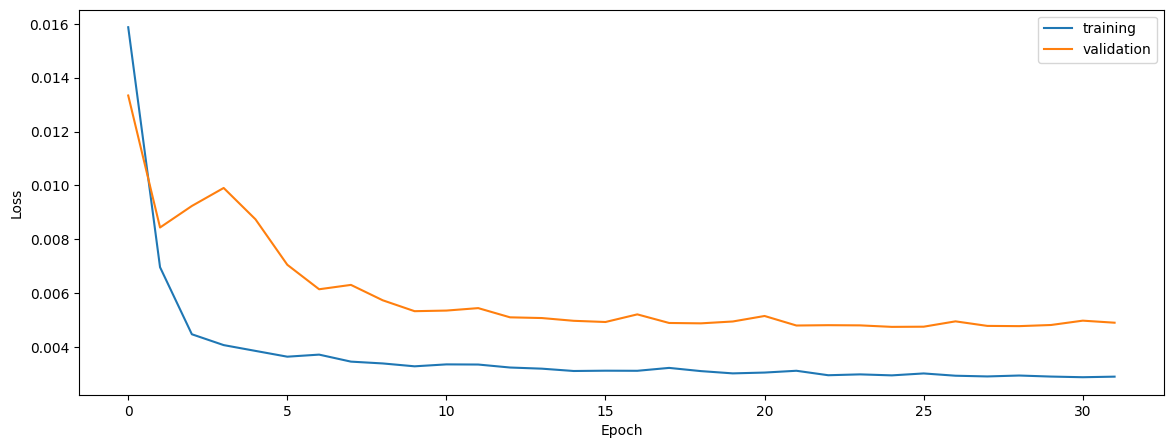

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


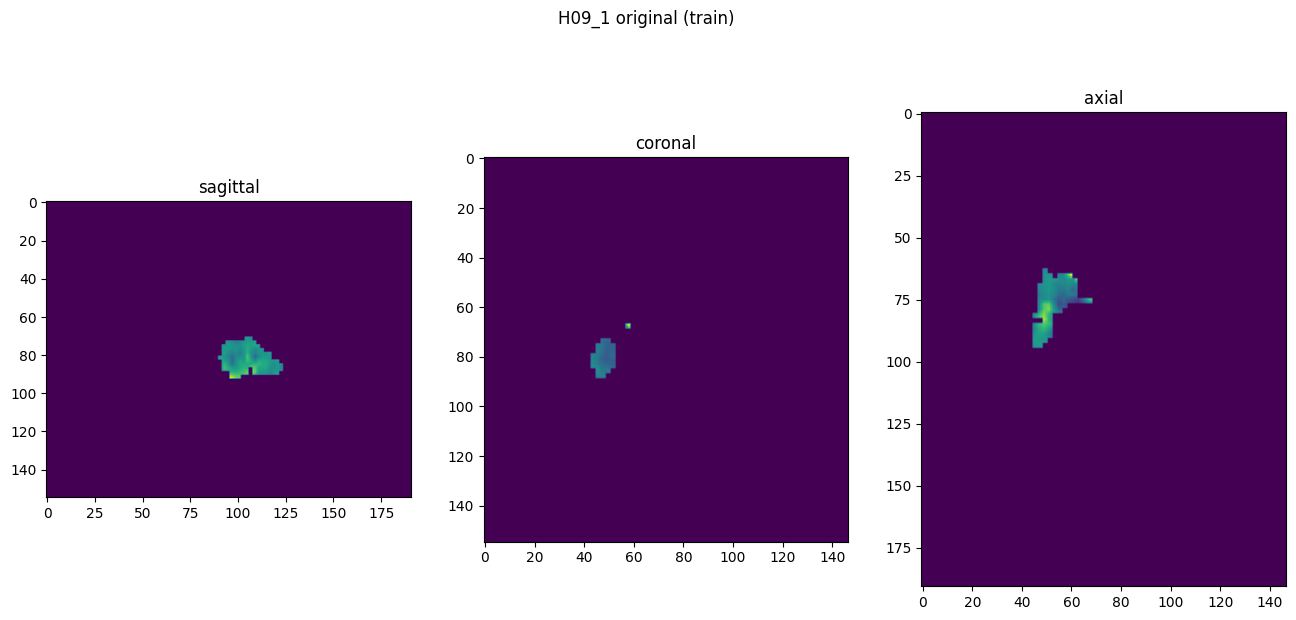

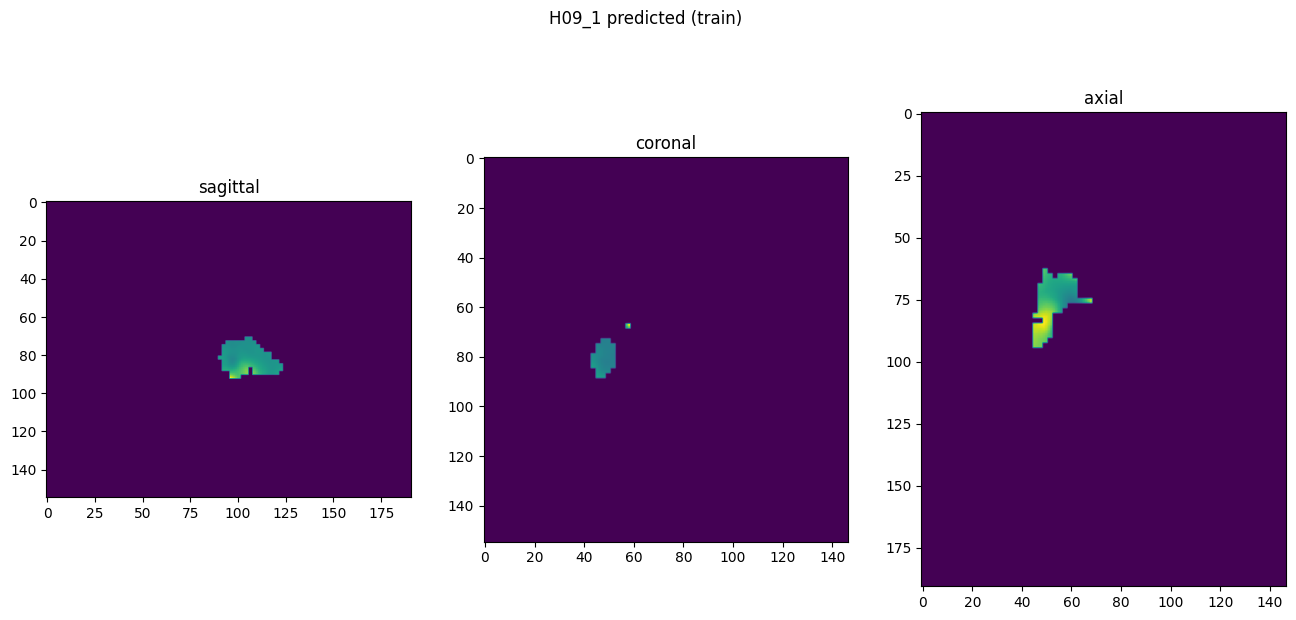

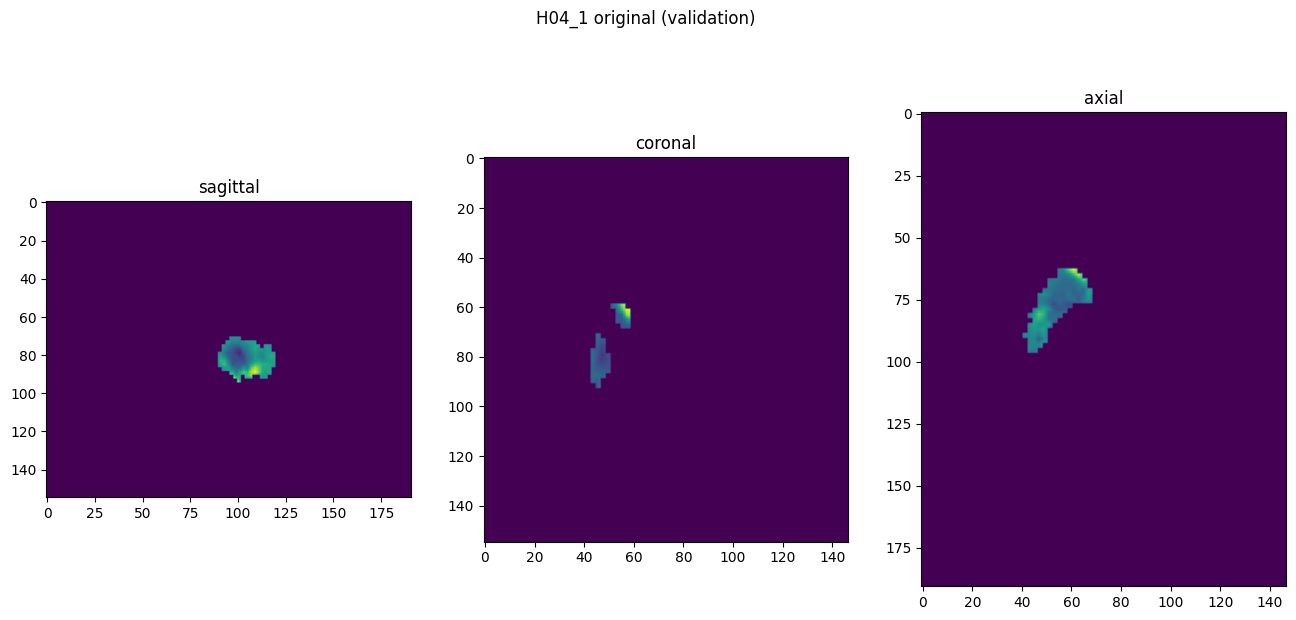

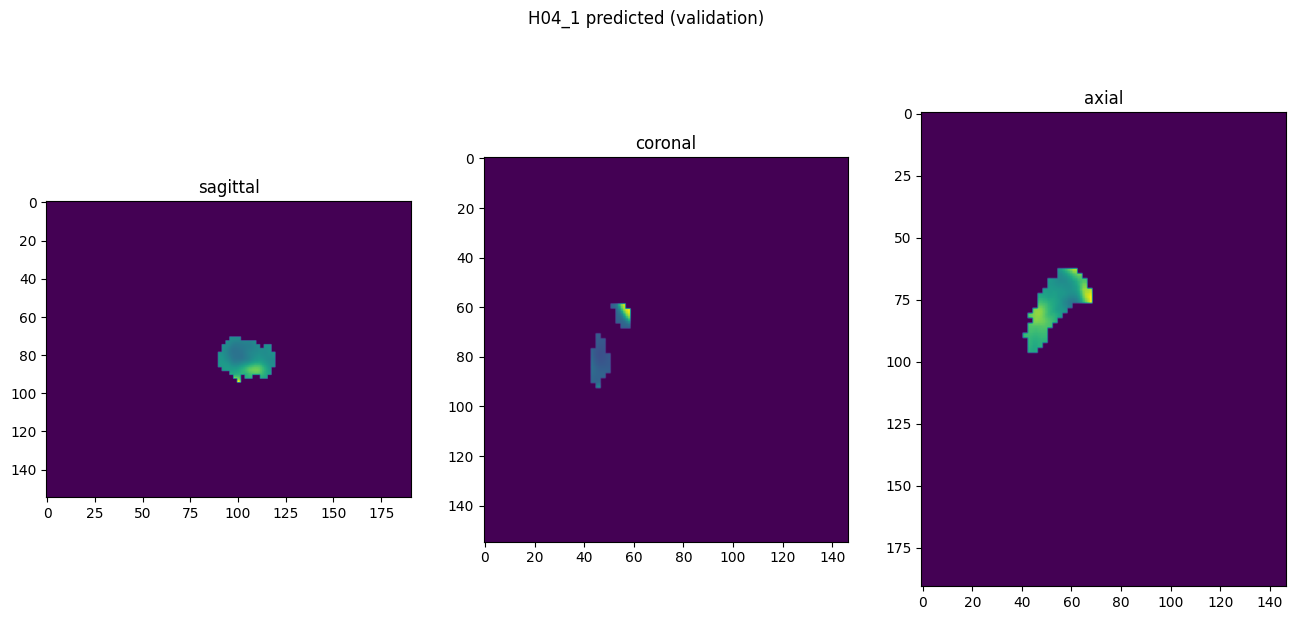

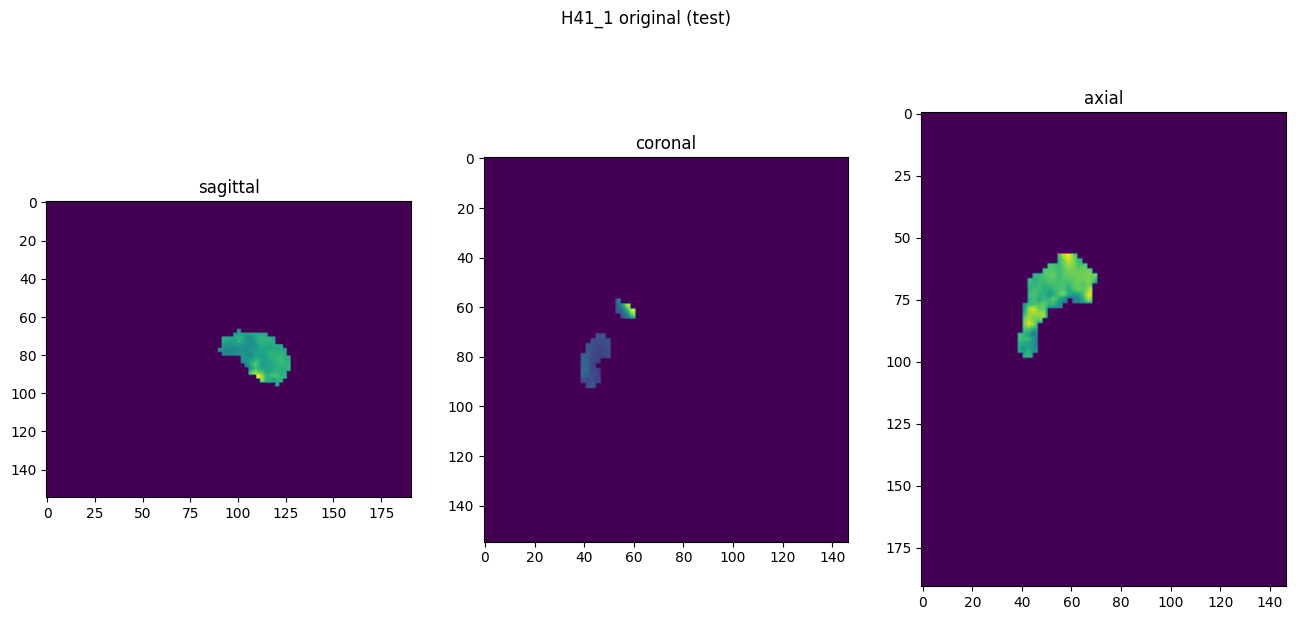

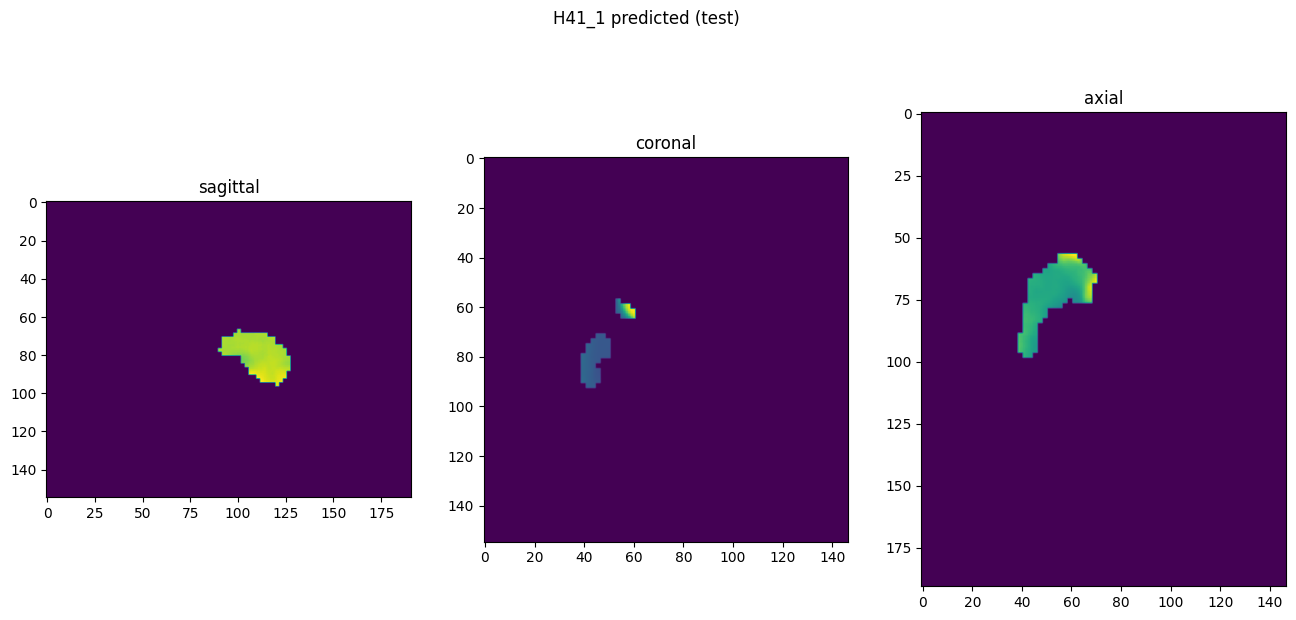

In [10]:
showResults(model, gen, threshold=None, background=False)